## ECE495 Lab2: Krichmar Path Planning using Nengo

This Lab uses Nengo to find the optimal path of a square or rectangular map using Krichmar's spike-wave propagation algorithm. The objectives of this lab are to:
- Implement Krichmar's spike-wave propagation algorithm using Nengo neurons
- Ensure the spike wave works for any rectangular or square map
- Utilize an "off-chip" AER to compute the fastest route to get from any starting point (location) to any ending point (location)

_Note: This is your assignment description and a proposed outline by which you can complete your assignment_
- The assignment is worth 60 points
- You may hardcode your connections for each of the three required maps _for a max score of 50/60_
- _**Be sure to print your final path for each map or save it somewhere in your repository so that I can check your work!**_

#### Set up

**Ensure you are using your [495 Virtual Environment](https://github.com/kaitlin-fair/495venv_setup) before you begin!**  
    
Import Nengo and other supporting libraries into your program to get started:

In [86]:
import matplotlib.pyplot as plt
import numpy as np

import nengo

from nengo.processes import Piecewise
from nengo.processes import WhiteSignal

### Input Maps

Check that your spike-wave propagation and AER work for these three maps:
 
(a) The following $3 \times 3$ array with start location 0 (top left) and end location 8 (bottom right). 
$$\begin{bmatrix} 1 & 2 & 1 \\
                  1 & 3 & 5 \\
                  7 & 1 & 1
                      \end{bmatrix}$$

(b) The following $3 \times 4$ array with start location 0 and end location 11.
$$\begin{bmatrix} 1 & 2 & 1 & 6 \\
                  1 & 3 & 5 & 3 \\
                  7 & 1 & 4 & 1
                      \end{bmatrix}$$

(c) The following $5 \times 5$ array with start location 10 and end location 4.
$$\begin{bmatrix} 1 & 3 & 7 & 2 & 1\\
                  3 & 1 & 5 & 3 & 1\\
                  3 & 2 & 6 & 1 & 2\\
                  3 & 1 & 5 & 6 & 1\\
                  2 & 2 & 1 & 1 & 2
                      \end{bmatrix}$$


In [87]:


map1 = np.array([

   [1, 2, 1],
   [1, 3, 5],   
   [7, 1, 1],

])

map2 = np.array([
    
   [1, 2, 1, 6],
   [1, 3, 5, 3],
   [7, 1, 4, 1],
])

map3 = np.array([
    
   [1, 3, 7, 2, 1],
   [3, 1, 5, 3, 1],
   [3, 2, 6, 1, 2],
   [3, 1, 5, 6, 1],
   [2, 2, 1, 1, 2],
   
])

# starting and ending values
map1start = [0,0]
map1end = [2,2]


# One map at a time
# numpy.shape outputs the location
desired_map= map1
rows,cols=desired_map.shape # numpy shape returns the coordinates


# # use class to organize location and connections for each map - this is an idea to track weights and connections
# class blockInfo:
#     def __init__(self):   # this is similar to a struct in C apparently
#         self.neighbors = []
#         self.delay = 0
# determine delays for each map location

map_delay_vals = desired_map

# create an empty list to append stuff to store map locations but out of neurons
model=nengo.Network(label="PathPlanning")
with model:
   # Creating a piecewise for an input first...
   inp_node = nengo.Node(Piecewise({0: 1, .25: 0})) # piecewise function from inhibition lab as a generic piecewise input
   map_neurons = []
   for i in range(rows):
      row=[]
      for j in range(cols):
         row.append(nengo.Ensemble(100, dimensions=1))
      map_neurons.append(row) # was previously locations list

# We'll make a simple object to implement the delayed connection
class Delay:
   def __init__(self, dimensions, timesteps=50):
      self.history = np.zeros((timesteps, dimensions))
      self.start = False
      self.stop = False

   def step(self, t, x): # this is for inhibition
      self.history = np.roll(self.history, -1)
      self.history[-1] = x
        
      if(self.history[0]>.8):
         self.start=True
      if(self.history[0]<.25 and self.start==True):
         self.stop=True
      if self.stop:
         return 0
      else:
         return self.history[0]
         
      
   

# This section creates delays for each block
dt = 0.001 # default nengo timestep
with model:
      delay_neurons = []
      for i in range(rows):
         row=[]
         for k in range(cols):
            delay = Delay(1, timesteps=int(map_delay_vals[i][j] / dt))
            row.append(nengo.Node(delay.step, size_in=1, size_out=1)) # appending a delay node to each rows
         delay_neurons.append(row) # was previously locations list

         # INDEX THESE!! So that you have a 3x3 list of delay_nodes -- just like map_neurons...
         # Attempted to index ^ new delay section



In [88]:

# connections start after this part  - each map location's neighbors  
# creating nengo versions of all of these connections above the original code which uses temp list append
with model:

   # connect piecewise to your first block
   nengo.Connection(inp_node, delay_neurons[map1start[0]][map1start[1]])
  
   for i in range(rows): # check all the corners first then switch the 
      
      for j in range(cols): 
         nengo.Connection(delay_neurons[i][j],map_neurons[i][j]) # connects delays to ensembles for every single slot!
         # top left corner 
         if (i== 0) and (j==0):

            nengo.Connection(map_neurons[i][j], delay_neurons[i][j+1]) # one to the right
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j]) # one down!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j+1]) # diagonal down right!


         #  top right corner
         elif (i== 0) and (j==cols-1):
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j-1]) # one to the left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j]) # one down!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j]) # diagonal down left!

         # bottom left corner 
         elif (i== rows-1) and (j==0):
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j]) # one unit straight up!
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j+1]) # one unit right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j+1]) # diagonal up right!

         # bottom right corner 
         elif (i== rows-1) and (j==cols-1):
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j-1]) # one unit left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j]) # one unit up!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j-1]) # diagonal up left!
   
         # top edge
         elif (i== 0):
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j-1]) # one unit left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j+1]) # one unit right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j]) # one down!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j+1]) # diagonal down right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j-1]) # diagonal down left!
         
         # bottom edge
         elif (i== rows-1):
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j-1]) # one unit left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j]) # one unit up!
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j+1]) # one to the right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j+1]) # diagonal up right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j-1]) # diagonal up left!

         # left edge
         elif (j==0):
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j]) # one unit up!
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j+1]) # one to the right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j]) # one down!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j+1]) # diagonal up right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j+1]) # diagonal down right!

         # right edge
         elif (cols-1):
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j]) # one unit up!
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j-1]) # one unit left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j]) # one down!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j-1]) # diagonal up left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j-1]) # diagonal down left!

         # ELSE for all the internal ones! (should be 8)
         else:
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j]) # one unit up!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j]) # one down!
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j-1]) # one unit left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i][j+1]) # one to the right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j+1]) # diagonal up right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j-1]) # diagonal up left!
            nengo.Connection(map_neurons[i][j],delay_neurons[i+1][j+1]) # diagonal down right!
            nengo.Connection(map_neurons[i][j],delay_neurons[i-1][j-1]) # diagonal down left!
         


### Set up and run your Nengo model to implement the spike-wave propagation
_Be sure to generalize or take the 10 points deduction!_

Hints: 
- Use a piecewise function to kick off the spike wave, then turn off your input and let the wave do the rest. Be sure this input connects to your _start location._
- Use a Nengo Ensemble for each map location (you can use an Ensemble array, a multidimensional ensemble, or a list of ensembles). Every map location has anywhere from 3 (corner locations) to 8 (inside locations) neighbors to which it can send a spike. Be careful with your connections! I personally said each of them had 8 possible locations and then deleted any locations that were "off-map", but do what makes the most sense to you. 
- Create a delay node to emulate an axonal delay from Krichmar's algorithm. Each map location should have a delay equal to the weight (difficulty of traversal) of the location.
- Implementing inhibition is _difficult_! Recall from Krichmar's algorithm that once a map location fires, it should not fire again. If you can't get the inhibition to work, instead try to add another function to your delay node that turns off a map location once it's sent the spike wave forward

In [89]:
# Probing to check if delay works...
with model:
    neuron_probe_list = []

    for i in range(rows):
        for j in range(cols):
            neuron_probe_list.append(nengo.Probe(map_neurons[i][j], synapse=0.01))


HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

HtmlProgressBar cannot be displayed. Please use the TerminalProgressBar. It can be enabled with `nengo.rc['progress']['progress_bar'] = 'nengo.utils.progress.TerminalProgressBar'`.

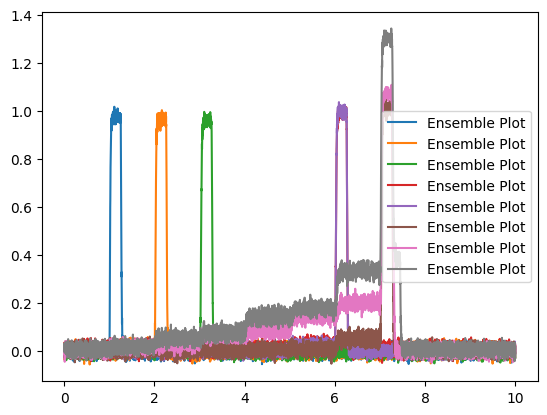

In [90]:
sim_time = 10
# Now run your simulation and plot the results after creating the probe
with nengo.Simulator(model) as sim:
# Run it for 5 seconds
    sim.run(sim_time)

    #plot
    plt.figure()
    #plt.plot(sim.trange(), sim.data[neuron_probe_list[7]], label="Ensemble Plot") 
for i in range(8):
    plt.plot(sim.trange(), sim.data[neuron_probe_list[i]], label="Ensemble Plot")

    plt.legend(loc="best")

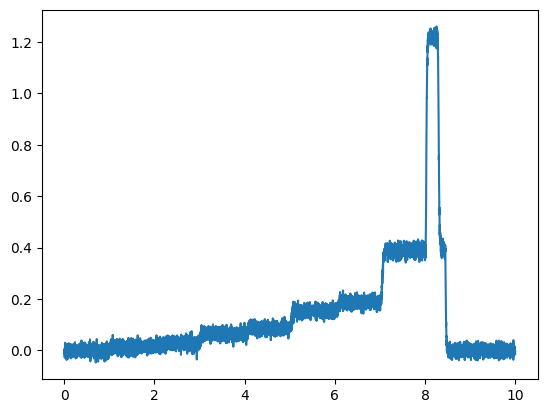

In [91]:
plt.figure()
# for i in range(8):
#     plt.plot(sim.trange(), sim.data[neuron_probe_list[i]], label="Ensemble Plot")
plt.plot(sim.trange(), sim.data[neuron_probe_list[8]], label="Ensemble Plot") 

### Create AER off-neuron
_Pay attention to how Krichmar says he uses the AER to determine the path_  

Hints:
- The AER contains a location and a time of first spike.
- Start at the end location and work backward!
- I found that by looking at the first spike times of all possible neighboring map locations and choosing the smallest time allowed me to work from end node to start node for my optimal path.

In [96]:
first_spike_list = []

# Iterate through all probes -- all spike values greater than .8
for i in range(0,len(neuron_probe_list)):
        aer = sim.data[neuron_probe_list[i]][:,0]>.8
        spikes_locs = np.where(aer == True)
        if np.asarray(spikes_locs).size == 0: # if there was no first spike value
            first_spike = sim_time/dt  # then set it returns a high value so that
        else:
            first_spike = np.min(spikes_locs)
            first_spike_list.append(first_spike)

initial_array = np.array(first_spike_list)
reshaped_spike_list = initial_array.reshape(rows,cols)




### Print your optimal path
_Be sure to show your results_  

Some options:
- You can print your map locations as x- and y- coordinates (examples: start_loc = [0,0] or [2,0]) or flattened locations (examples: start_loc = 0 or 10)
- You can create a picture of a map (like in Krichmar's paper) where you draw out your final path